In [1]:
import os
import torch
import torchvision
print("CUDA is available:", torch.cuda.is_available())
import sys
# {sys.executable} -m pip install opencv-python matplotlib
# {sys.executable} -m pip install "git+https://github.com/facebookresearch/sam2.git"
%pip install opencv-python matplotlib
# %pip install git+https://github.com/facebookresearch/sam2.git


folder_name = "../checkpoints"
images_folder = "images"
file_url = "https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt"
file_name = os.path.join(folder_name, "sam2.1_hiera_large.pt")


os.makedirs(folder_name, exist_ok=True)
os.makedirs(images_folder, exist_ok=True)
import requests

def download_file(save_path, url):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(save_path, "wb") as file:
            for chunk in response.iter_content(1024):
                file.write(chunk)
        print(f"Downloaded: {save_path}")
    else:
        print(f"Failed to download {url}")

download_file(file_name, file_url)

img_urls = [
    "https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/truck.jpg",
    "https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/groceries.jpg"
]

for img_url in img_urls:
    img_name = os.path.join(images_folder, os.path.basename(img_url))
    download_file(img_name, img_url)
# !mkdir -p images
# !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/truck.jpg
# !wget -P images https://raw.githubusercontent.com/facebookresearch/sam2/main/notebooks/images/groceries.jpg 
# !mkdir -p ../checkpoints/
# !wget -P ../checkpoints/ https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt

CUDA is available: True
Note: you may need to restart the kernel to use updated packages.
Downloaded: ../checkpoints\sam2.1_hiera_large.pt
Downloaded: images\truck.jpg
Downloaded: images\groceries.jpg


In [2]:
import numpy as np
np.random.seed(2025)

def show_mask(mask, ax, random_color=False, borders = True):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        color = np.array([30/255, 144/255, 255/255, 0.6])
    h, w = mask.shape[-2:]
    mask = mask.astype(np.uint8)
    mask_image =  mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    if borders:
        import cv2
        contours, _ = cv2.findContours(mask,cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        # Try to smooth contours
        contours = [cv2.approxPolyDP(contour, epsilon=0.01, closed=True) for contour in contours]
        mask_image = cv2.drawContours(mask_image, contours, -1, (1, 1, 1, 0.5), thickness=2)
    ax.imshow(mask_image)

def show_points(coords, labels, ax, marker_size=375):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)

def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

def show_masks(image, masks, scores, point_coords=None, box_coords=None, input_labels=None, borders=True):
    for i, (mask, score) in enumerate(zip(masks, scores)):
        plt.figure(figsize=(10, 10))
        plt.imshow(image)
        show_mask(mask, plt.gca(), borders=borders)
        if point_coords is not None:
            assert input_labels is not None
            show_points(point_coords, input_labels, plt.gca())
        if box_coords is not None:
            # boxes
            show_box(box_coords, plt.gca())
        if len(scores) > 1:
            plt.title(f"Mask {i+1}, Score: {score:.3f}", fontsize=18)
        plt.axis('off')
        plt.show()

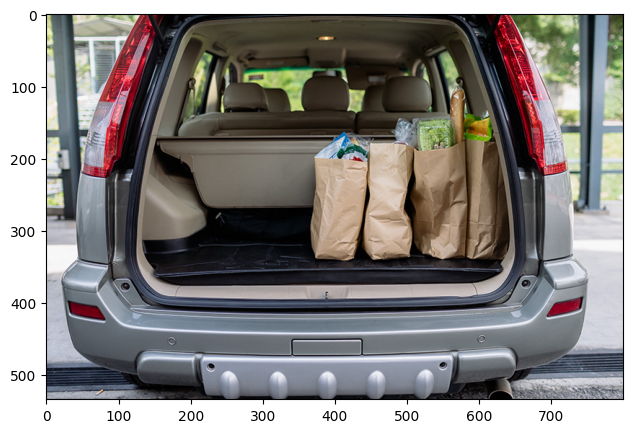

In [3]:
from PIL import Image
import matplotlib.pyplot as plt
img = np.array(Image.open("images/groceries.jpg").convert("RGB"))
plt.figure(figsize = (10,5))
plt.imshow(img, cmap = "gray")
plt.show()

In [22]:
from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
folder_name = "checkpoints"
os.makedirs(folder_name, exist_ok = True)


In [24]:
sam2_checkpoint = "C:/Users/Nodir/anaconda3/envs/checkpoints/sam2.1_hiera_large.pt"
model_cfg = "C:/Users/Nodir/anaconda3/envs/sam2/sam2/configs/sam2.1/sam2.1_hiera_l.yaml"

device = "cuda" if torch.cuda.is_available() else "cpu"
sam2_model = build_sam2(model_cfg, sam2_checkpoint, device=device)
predictor = SAM2ImagePredictor(sam2_model)

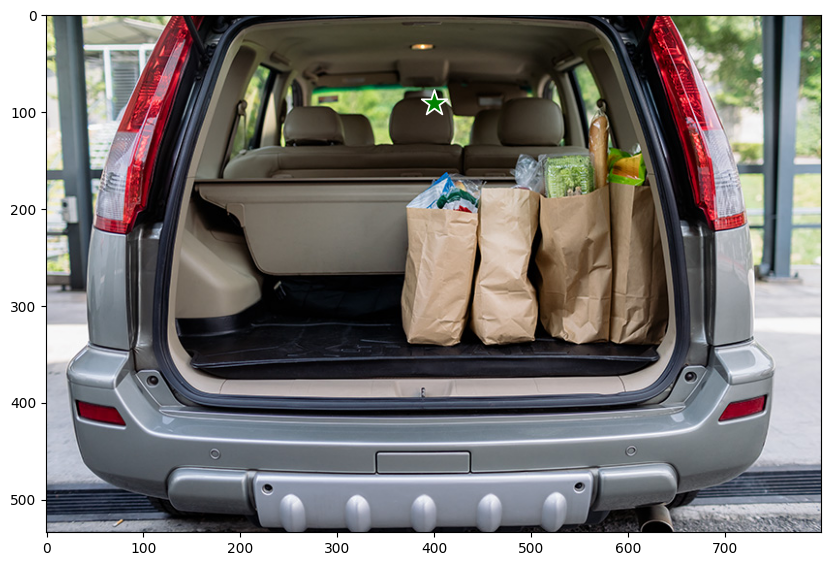

In [26]:
predictor.set_image(img)
input_point = np.array([[400, 90]])
input_label = np.array([1])
plt.figure(figsize=(10, 10))
plt.imshow(img)
show_points(input_point, input_label, plt.gca())
plt.axis('on')
plt.show()

In [28]:
print(predictor._features["image_embed"].shape, predictor._features["image_embed"][-1].shape)

masks, scores, logits = predictor.predict(
    point_coords=input_point,
    point_labels=input_label,
    multimask_output=True, # False
)
sorted_ind = np.argsort(scores)[::-1]
masks = masks[sorted_ind]
scores = scores[sorted_ind]
logits = logits[sorted_ind]

torch.Size([1, 256, 64, 64]) torch.Size([256, 64, 64])


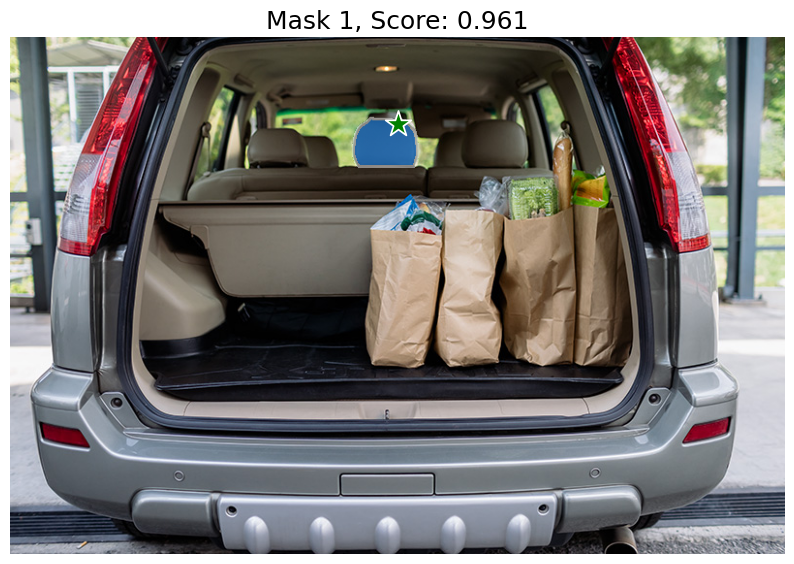

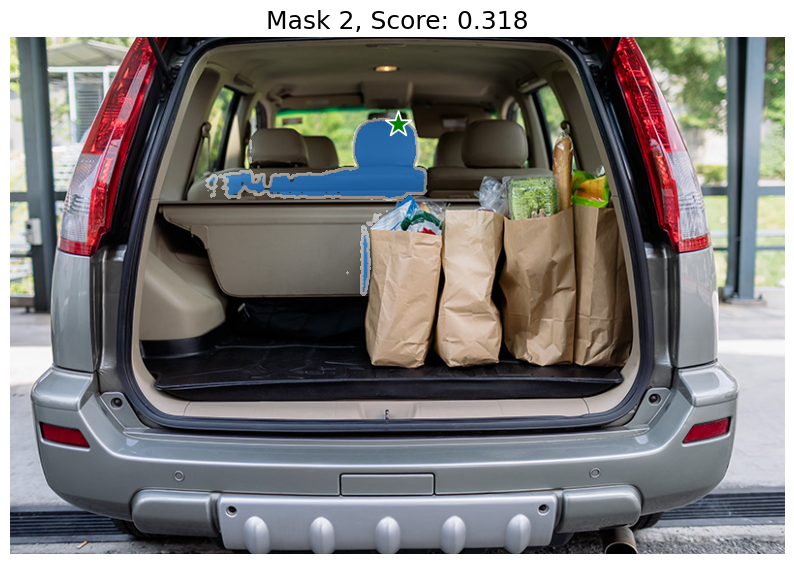

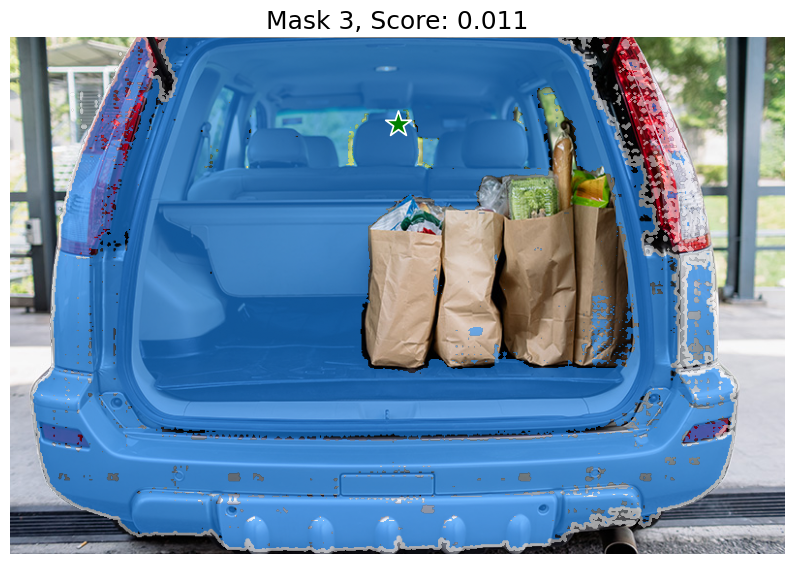

In [30]:
show_masks(img, masks, scores, point_coords=input_point, input_labels=input_label, borders=True)